# EDA

In [44]:
import numpy as np 
import pandas as pd 
import os
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.preprocessing import minmax_scale
import IPython.display as ipd
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('/kaggle/input/dysarthria-detection/torgo_data/data.csv')
df

,is_dysarthria,gender,filename
0,non_dysarthria,female,torgo_data/non_dysarthria_female/FC03_Session2...
1,non_dysarthria,female,torgo_data/non_dysarthria_female/FC02_Session3...
2,non_dysarthria,female,torgo_data/non_dysarthria_female/FC02_Session3...
3,non_dysarthria,female,torgo_data/non_dysarthria_female/FC03_Session2...
4,non_dysarthria,female,torgo_data/non_dysarthria_female/FC03_Session1...
...,...,...,...
1995,dysarthria,male,torgo_data/dysarthria_male/M03_Session2_0144.wav
1996,dysarthria,male,torgo_data/dysarthria_male/M02_Session1_0005.wav
1997,dysarthria,male,torgo_data/dysarthria_male/M03_Session2_0040.wav
1998,dysarthria,male,torgo_data/dysarthria_male/M03_Session2_0260.wav


In [4]:
df['filename'] = df['filename'].apply(lambda x: os.path.join('/kaggle/input/dysarthria-detection',x))

In [5]:
df

,is_dysarthria,gender,filename
0,non_dysarthria,female,/kaggle/input/dysarthria-detection/torgo_data/...
1,non_dysarthria,female,/kaggle/input/dysarthria-detection/torgo_data/...
2,non_dysarthria,female,/kaggle/input/dysarthria-detection/torgo_data/...
3,non_dysarthria,female,/kaggle/input/dysarthria-detection/torgo_data/...
4,non_dysarthria,female,/kaggle/input/dysarthria-detection/torgo_data/...
...,...,...,...
1995,dysarthria,male,/kaggle/input/dysarthria-detection/torgo_data/...
1996,dysarthria,male,/kaggle/input/dysarthria-detection/torgo_data/...
1997,dysarthria,male,/kaggle/input/dysarthria-detection/torgo_data/...
1998,dysarthria,male,/kaggle/input/dysarthria-detection/torgo_data/...


In [6]:
#Getting a random sample to visualize from each class
male_dysarthric = df[(df['gender']=='male') & (df['is_dysarthria']=='dysarthria')].sample(1)
female_dysarthric = df[(df['gender']=='female') & (df['is_dysarthria']=='dysarthria')].sample(1)
male_non_dysarthric = df[(df['gender']=='male') & (df['is_dysarthria']=='non_dysarthria')].sample(1)
female_non_dysarthric = df[(df['gender']=='female') & (df['is_dysarthria']=='non_dysarthria')].sample(1)

In [7]:
male_dysarthric

,is_dysarthria,gender,filename
1798,dysarthria,male,/kaggle/input/dysarthria-detection/torgo_data/...


In [8]:
# The dysarthric male audio
ipd.Audio(male_dysarthric.iloc[0].filename)

In [9]:
female_dysarthric

,is_dysarthria,gender,filename
952,dysarthria,female,/kaggle/input/dysarthria-detection/torgo_data/...


In [10]:
# The dysarthric female audio
ipd.Audio(female_dysarthric.iloc[0].filename)

In [11]:
male_non_dysarthric

,is_dysarthria,gender,filename
1381,non_dysarthria,male,/kaggle/input/dysarthria-detection/torgo_data/...


In [12]:
# The non-dysarthric male audio
ipd.Audio(male_non_dysarthric.iloc[0].filename)

In [13]:
female_non_dysarthric

,is_dysarthria,gender,filename
495,non_dysarthria,female,/kaggle/input/dysarthria-detection/torgo_data/...


In [14]:
# The non-dysarthric female audio
ipd.Audio(female_non_dysarthric.iloc[0].filename)

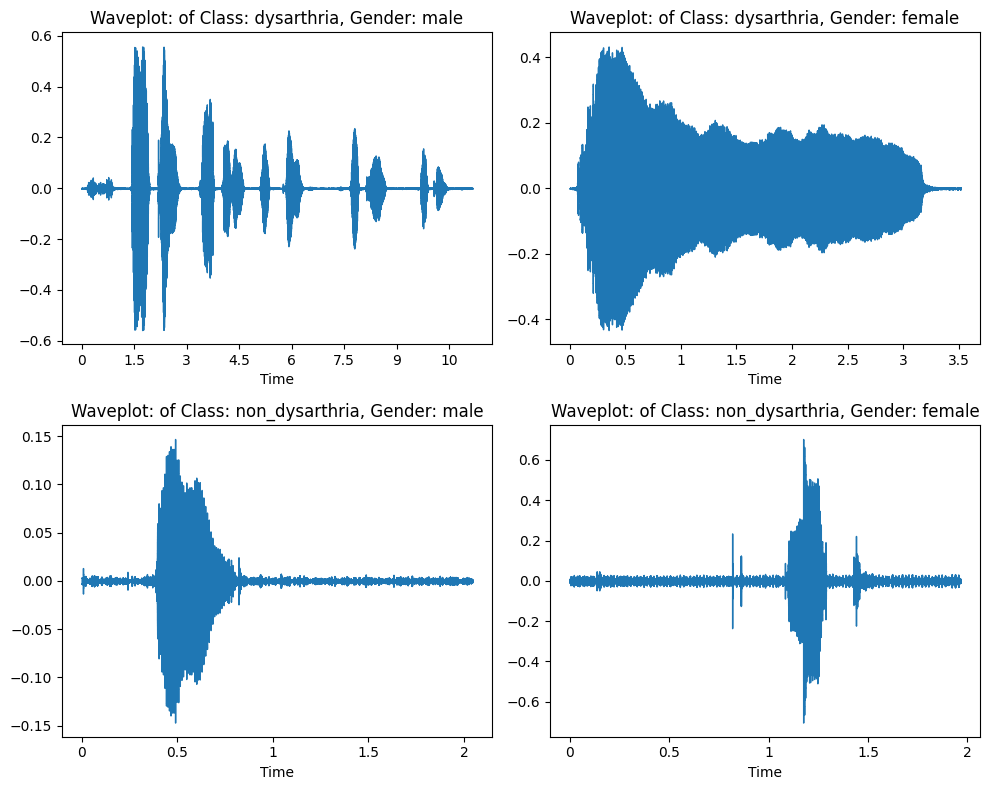

In [15]:
file_paths = [male_dysarthric, female_dysarthric, male_non_dysarthric, female_non_dysarthric]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, ax in enumerate(axes.flat):
    y, sr = librosa.load(file_paths[i].iloc[0].filename)
    librosa.display.waveshow(y, sr=sr, ax=ax)
    ax.set_title(f"Waveplot: of Class: {file_paths[i].iloc[0].is_dysarthria}, Gender: {file_paths[i].iloc[0].gender}")

plt.tight_layout()
plt.show()

# Epoch extraction (ZFF):

In [60]:
# Zero Frequency Filtering (ZFF)
def zero_frequency_filter(signal_data, fs, win_len_ms=10):
    if len(signal_data) < 2:
        return np.array([])
    diff_signal = np.diff(signal_data)
    zff_signal = np.cumsum(np.cumsum(diff_signal))  
    win_len = int((win_len_ms / 1000) * fs)
    if win_len > len(zff_signal):
        win_len = len(zff_signal)
    mean_trend = np.convolve(zff_signal, np.ones(win_len)/win_len, mode='same')
    zff_filtered = zff_signal - mean_trend
    return zff_filtered

def detect_epochs(zff_signal):
    zero_crossings = np.where((zff_signal[:-1] < 0) & (zff_signal[1:] >= 0))[0]
    return zero_crossings

In [61]:
import numpy as np
import librosa
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

In [62]:
def compute_pp_features(epochs, fs):
     # Mean F0, Jitter, RAP, PPQ, and PPF from detected epochs
    if len(epochs) < 2:
        return np.zeros(6) 
    T0 = np.diff(epochs) / fs  # pitch period in secs
    F0 = 1/T0  

    mean_F0 = np.mean(F0)
    std_F0 = np.std(F0)
    jitter = np.mean(np.abs(F0[:-1] - F0[1:])) / mean_F0 

    if len(T0) >= 3:
        RAP = np.mean([np.abs(F0[i] - np.mean(F0[i-1:i+2])) for i in range(1, len(F0)-1)])
        RAP /= mean_F0
    else:
        RAP = 0

    if len(T0) >= 5:
        PPQ = np.mean([np.abs(F0[i] - np.mean(F0[i-2:i+3])) for i in range(2, len(F0)-2)])
        PPQ /= mean_F0
    else:
        PPQ = 0

    PPF_threshold = 0.005 
    PPF = np.sum(T0 > PPF_threshold) / len(T0)
    return np.array([mean_F0, std_F0, jitter, RAP, PPQ, PPF])


def extract_mfcc_features(signal, fs, n_mfcc=52):
    preemphasized_signal = librosa.effects.preemphasis(signal)
    mfccs = librosa.feature.mfcc(y=preemphasized_signal, sr=fs, n_mfcc=n_mfcc)
    return np.mean(mfccs, axis=1)

def feature_extraction_only_pp(df):
    features = []
    for i, record in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            speech, fs = librosa.load(record['filename'])

            zff_output = zero_frequency_filter(speech, fs)
            epochs = detect_epochs(zff_output)
            pp_features = compute_pp_features(epochs, fs)

            all_features = np.concatenate([pp_features])  # (6 features)
            
            features.append(np.append(all_features, [record['is_dysarthria'], record['gender']]))  
        
        except Exception as e:
            print(f"Error processing {record['filename']}: {e}")
    column_names = (
        ['mean_F0', 'std_F0', 'jitter', 'RAP', 'PPQ', 'PPF'] + ['class', 'gender'])
    
    return pd.DataFrame(features, columns=column_names)


def feature_extraction_only_mfcc(df):
    features = []
    for i, record in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            speech, fs = librosa.load(record['filename'])
            mfcc_features = extract_mfcc_features(speech, fs)  # (52 features)
            all_features = np.concatenate([mfcc_features])
            features.append(np.append(all_features, [record['is_dysarthria'], record['gender']]))  
        except Exception as e:
            print(f"Error processing {record['filename']}: {e}")

    column_names = (
        [f"MFCC_{i}" for i in range(52)] + ['class', 'gender'])
    return pd.DataFrame(features, columns=column_names)


def feature_extraction_mfcc_and_pp(df):
    features = []
    for i, record in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            speech, fs = librosa.load(record['filename'])

            zff_output = zero_frequency_filter(speech, fs)
            epochs = detect_epochs(zff_output)
            pp_features = compute_pp_features(epochs, fs)  # (6 features)
            mfcc_features = extract_mfcc_features(speech, fs)  # (52 features)

            all_features = np.concatenate([pp_features, mfcc_features])  # (6 + 52 = 58 features)
            features.append(np.append(all_features, [record['is_dysarthria'], record['gender']]))  
        except Exception as e:
            print(f"Error processing {record['filename']}: {e}")

    column_names = (
        ['mean_F0', 'std_F0', 'jitter', 'RAP', 'PPQ', 'PPF'] + 
        [f"MFCC_{i}" for i in range(52)] +
        ['class', 'gender']
    )
    return pd.DataFrame(features, columns=column_names)


# MFCC (52)

In [19]:
data_with_feat_mfcc = feature_extraction_only_mfcc(df)
data_with_feat_mfcc['class'] = data_with_feat_mfcc['class'].replace('non_dysarthria',0)
data_with_feat_mfcc['class'] = data_with_feat_mfcc['class'].replace('dysarthria',1)
data_with_feat_mfcc['gender'] = data_with_feat_mfcc['gender'].replace('male', 1)
data_with_feat_mfcc['gender'] = data_with_feat_mfcc['gender'].replace('female', 0)
data_with_feat_mfcc

 30%|██▉       | 594/2000 [00:11<00:24, 56.97it/s]<ipython-input-18-e8cf0d122aca>:60: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, fs = librosa.load(record['filename'])
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 30%|███       | 609/2000 [00:11<00:22, 62.66it/s]

Error processing /kaggle/input/dysarthria-detection/torgo_data/dysarthria_female/F01_Session1_0068.wav: 


 77%|███████▋  | 1549/2000 [00:26<00:08, 54.78it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=209
  warnings.warn(
 78%|███████▊  | 1563/2000 [00:26<00:07, 58.80it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=583
  warnings.warn(
 80%|███████▉  | 1593/2000 [00:27<00:06, 58.67it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=581
  warnings.warn(
 83%|████████▎ | 1668/2000 [00:28<00:05, 58.44it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=185
  warnings.warn(
 85%|████████▌ | 1703/2000 [00:28<00:04, 62.66it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal o

,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,MFCC_44,MFCC_45,MFCC_46,MFCC_47,MFCC_48,MFCC_49,MFCC_50,MFCC_51,class,gender
0,-319.7045,35.161507,-66.34302,51.268147,-50.792416,34.19954,-29.19774,17.997763,-9.4621935,-0.5122181,...,-4.5058756,-1.5363845,-5.0564704,-3.4387124,-4.2227654,-2.2731867,0.4243103,-0.49626946,0,0
1,-395.44254,40.966072,-64.21012,49.29909,-52.021427,34.75533,-20.61536,25.536705,-7.5747924,4.6627607,...,-6.344143,-4.169222,-6.5706644,-2.3804123,-3.0671916,-2.7551515,0.38413244,-0.8819986,0,0
2,-400.7094,45.508183,-73.22846,57.570812,-59.73956,40.009903,-23.322557,26.447178,-7.871122,5.9670362,...,-7.1083784,-3.794058,-6.653496,-3.121459,-4.4126153,-2.3347008,-0.13959113,-0.8432585,0,0
3,-303.36227,42.922634,-77.73571,44.11482,-58.83759,34.619595,-27.90659,18.597755,-10.9610815,4.2977843,...,-6.555074,-1.2236726,-3.9311428,-1.7308125,-1.85476,-2.1504872,0.38307458,-1.4279135,0,0
4,-380.4776,41.505455,-70.097115,60.845333,-55.586807,44.16475,-29.470608,26.530014,-8.528628,3.3341653,...,-6.7447896,-2.504473,-7.4847293,-1.6244006,-3.1706736,-2.378174,0.8780274,0.091998786,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,-402.0437,48.89409,-49.44366,37.44017,-35.224632,23.513338,-17.929684,8.643148,-9.682321,-4.864476,...,-1.2102699,0.2593692,-0.30640313,4.1314764,4.4224787,2.0771952,3.580518,4.074891,1,1
1995,-567.24225,53.42506,-24.851572,5.648115,-42.638477,14.371315,-28.034782,12.563507,-5.3071346,-2.4107144,...,-0.19318683,5.2797875,2.5829372,5.5325646,2.6679924,0.4258839,1.1258968,0.17784452,1,1
1996,-472.70474,55.216194,-48.241093,38.618504,-31.28108,22.451336,-14.904069,16.969027,-5.566646,1.9870967,...,-3.0755556,-0.32984915,-2.210794,3.444888,2.3652935,2.474335,5.7890086,3.5479848,1,1
1997,-406.1352,54.426342,-61.200016,50.883335,-42.66797,20.043901,-20.154718,17.3035,-13.471844,-4.6676664,...,-0.9948297,2.6853592,1.079636,2.7016742,1.9857001,3.738986,3.9398618,2.0509567,1,1


In [45]:
X_mfcc = data_with_feat_mfcc.drop(columns = ['class'])
X_mfcc.columns = X_mfcc.columns.astype(str)
y_mfcc = data_with_feat_mfcc['class']
X_mfcc = X_mfcc.astype(float)

X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc = train_test_split(X_mfcc, y_mfcc, test_size=0.2, stratify=y_mfcc, random_state = 42)

# to handle with NaN, Inf, or constant features
X_train_mfcc.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_mfcc.fillna(X_train_mfcc.mean(), inplace=True)
X_train_mfcc = X_train_mfcc.loc[:, X_train_mfcc.nunique() > 1] 
X_train_mfcc = X_train_mfcc.astype(float)
y_train_mfcc = y_train_mfcc.astype(int)

scaler = StandardScaler()
X_train_mfcc = scaler.fit_transform(X_train_mfcc)
X_test_mfcc = scaler.transform(X_test_mfcc)


In [46]:
from sklearn.model_selection import GridSearchCV

param_grid=[
    {'C':[0.5,1,10,100, 1000],
     'gamma':[10,1,0.1,0.001,0.00001, 0.000001],
     'kernel':['rbf'],
    }
]

optional_params=GridSearchCV(SVC(),param_grid,cv=5,scoring='accuracy',verbose=0)
optional_params.fit(X_train_mfcc,y_train_mfcc)
print("Best parameters for original dataset:")
print(optional_params.best_params_)

Best parameters for original dataset:
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [47]:
model_mfcc = SVC(kernel='rbf', gamma=1e-1, C=10)
model_mfcc.fit(X_train_mfcc, y_train_mfcc)

from sklearn.metrics import accuracy_score
predictions = model_mfcc.predict(X_test_mfcc) 
print(100*accuracy_score(y_test_mfcc, predictions), "% accuracy")

98.25 % accuracy


# Pitch perturbation features:

In [63]:
data_with_feat_pp = feature_extraction_only_pp(df)
data_with_feat_pp['class'] = data_with_feat_pp['class'].replace('non_dysarthria',0)
data_with_feat_pp['class'] = data_with_feat_pp['class'].replace('dysarthria',1)
data_with_feat_pp['gender'] = data_with_feat_pp['gender'].replace('male', 1)
data_with_feat_pp['gender'] = data_with_feat_pp['gender'].replace('female', 0)
data_with_feat_pp

 30%|██▉       | 596/2000 [00:08<00:23, 58.69it/s]<ipython-input-62-e8cf0d122aca>:38: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, fs = librosa.load(record['filename'])
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 31%|███       | 614/2000 [00:09<00:20, 66.37it/s]

Error processing /kaggle/input/dysarthria-detection/torgo_data/dysarthria_female/F01_Session1_0068.wav: 


 78%|███████▊  | 1565/2000 [00:23<00:08, 50.23it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 2000/2000 [00:33<00:00, 59.82it/s]
<ipython-input-63-a6eb1be564d1>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_with_feat_pp['class'] = data_with_feat_pp['class'].replace('dysarthria',1)
<ipython-input-63-a6eb1be564d1>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly ca

,mean_F0,std_F0,jitter,RAP,PPQ,PPF,class,gender
0,892.0862540109244,1817.016996762231,0.8820037813786802,0.5460245477967903,0.6082710883388306,0.3198482932996207,0,0
1,579.1109456966853,1309.4467465746604,0.9981345772931383,0.6038637480624931,0.6385759463077616,0.6597938144329897,0,0
2,209.58793889877438,552.6779813062068,0.598110890260285,0.2968220626590871,0.3908106198640454,0.7795698924731183,0,0
3,653.4902709540128,1195.033710514541,0.8816065032258241,0.5293502331109314,0.6030262248013243,0.28641251221896386,0,0
4,320.3973689003504,881.9087366793063,1.038047736404847,0.6631407959922145,0.8013446820481728,0.6056338028169014,0,0
...,...,...,...,...,...,...,...,...
1994,951.9106163585204,1701.3172341534016,0.8428015377793727,0.5149307618803034,0.5732466560205125,0.4544419134396355,1,1
1995,489.62530217416816,713.9336106321923,0.8304498509285958,0.5077388895604817,0.542190506658813,0.305993690851735,1,1
1996,204.16447984382822,449.0409868238254,0.6898400325689013,0.4424321998658207,0.4832477392865525,0.7527777777777778,1,1
1997,1312.3655112258389,2025.0011636383658,0.6981899741345754,0.40979014959856114,0.4703435229365756,0.40955631399317405,1,1


In [64]:
X_pp = data_with_feat_pp.drop(columns = ['class'])
X_pp.columns = X_pp.columns.astype(str)
y_pp = data_with_feat_pp['class']
X_pp = X_pp.astype(float)

X_train_pp, X_test_pp, y_train_pp, y_test_pp = train_test_split(X_pp, y_pp, test_size=0.2, stratify=y_pp, random_state = 42)

# to handle with NaN, Inf, or constant features
X_train_pp.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_pp.fillna(X_train_pp.mean(), inplace=True)
X_train_pp = X_train_pp.loc[:, X_train_pp.nunique() > 1] 
X_train_pp = X_train_pp.astype(float)
y_train_pp = y_train_pp.astype(int)

scaler = StandardScaler()
X_train_pp = scaler.fit_transform(X_train_pp)
X_test_pp = scaler.transform(X_test_pp)

In [65]:
from sklearn.model_selection import GridSearchCV

param_grid=[
    {'C':[0.5,1,10,100, 1000],
     'gamma':[10,1,0.1,0.001,0.00001, 0.000001],
     'kernel':['rbf'],
    }
]

optional_params=GridSearchCV(SVC(),param_grid,cv=5,scoring='accuracy',verbose=0)
optional_params.fit(X_train_pp,y_train_pp)
print("Best parameters for original dataset:")
print(optional_params.best_params_)

Best parameters for original dataset:
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [66]:
model_pp = SVC(kernel='rbf', gamma=1e-1, C=10)
model_pp.fit(X_train_pp, y_train_pp)

from sklearn.metrics import accuracy_score
predictions = model_pp.predict(X_test_pp) 
print(100*accuracy_score(y_test_pp, predictions), "% accuracy")

76.75 % accuracy


# MFCC + PP features

In [67]:
data_with_feat_pp_mfcc = feature_extraction_mfcc_and_pp(df)
data_with_feat_pp_mfcc['class'] = data_with_feat_pp_mfcc['class'].replace('non_dysarthria',0)
data_with_feat_pp_mfcc['class'] = data_with_feat_pp_mfcc['class'].replace('dysarthria',1)
data_with_feat_pp_mfcc['gender'] = data_with_feat_pp_mfcc['gender'].replace('male', 1)
data_with_feat_pp_mfcc['gender'] = data_with_feat_pp_mfcc['gender'].replace('female', 0)
data_with_feat_pp_mfcc

 30%|██▉       | 596/2000 [00:13<00:33, 41.87it/s]<ipython-input-62-e8cf0d122aca>:76: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, fs = librosa.load(record['filename'])
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 30%|███       | 609/2000 [00:13<00:30, 45.57it/s]

Error processing /kaggle/input/dysarthria-detection/torgo_data/dysarthria_female/F01_Session1_0068.wav: 


 78%|███████▊  | 1551/2000 [00:34<00:14, 31.48it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=209
  warnings.warn(
 78%|███████▊  | 1565/2000 [00:34<00:12, 36.05it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=583
  warnings.warn(
 80%|███████▉  | 1599/2000 [00:35<00:11, 33.52it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=581
  warnings.warn(
 84%|████████▎ | 1670/2000 [00:37<00:08, 36.83it/s]/usr/lo

,mean_F0,std_F0,jitter,RAP,PPQ,PPF,MFCC_0,MFCC_1,MFCC_2,MFCC_3,...,MFCC_44,MFCC_45,MFCC_46,MFCC_47,MFCC_48,MFCC_49,MFCC_50,MFCC_51,class,gender
0,892.0862540109244,1817.016996762231,0.8820037813786802,0.5460245477967903,0.6082710883388306,0.3198482932996207,-319.7044982910156,35.16150665283203,-66.343017578125,51.26814651489258,...,-4.505875587463379,-1.5363844633102417,-5.0564703941345215,-3.4387123584747314,-4.2227654457092285,-2.273186683654785,0.4243102967739105,-0.49626946449279785,0,0
1,579.1109456966853,1309.4467465746604,0.9981345772931383,0.6038637480624931,0.6385759463077616,0.6597938144329897,-395.4425354003906,40.96607208251953,-64.21012115478516,49.29909133911133,...,-6.344142913818359,-4.169221878051758,-6.570664405822754,-2.3804123401641846,-3.0671916007995605,-2.7551515102386475,0.384132444858551,-0.881998598575592,0,0
2,209.58793889877438,552.6779813062068,0.598110890260285,0.2968220626590871,0.3908106198640454,0.7795698924731183,-400.70941162109375,45.508182525634766,-73.22846221923828,57.5708122253418,...,-7.1083784103393555,-3.794058084487915,-6.653495788574219,-3.1214590072631836,-4.4126152992248535,-2.3347008228302,-0.13959112763404846,-0.8432585000991821,0,0
3,653.4902709540128,1195.033710514541,0.8816065032258241,0.5293502331109314,0.6030262248013243,0.28641251221896386,-303.3622741699219,42.92263412475586,-77.73571014404297,44.11481857299805,...,-6.555074214935303,-1.22367262840271,-3.931142807006836,-1.7308125495910645,-1.8547600507736206,-2.150487184524536,0.3830745816230774,-1.4279135465621948,0,0
4,320.3973689003504,881.9087366793063,1.038047736404847,0.6631407959922145,0.8013446820481728,0.6056338028169014,-380.47760009765625,41.505455017089844,-70.09711456298828,60.845333099365234,...,-6.7447896003723145,-2.5044729709625244,-7.484729290008545,-1.6244006156921387,-3.1706736087799072,-2.378174066543579,0.8780273795127869,0.09199878573417664,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,951.9106163585204,1701.3172341534016,0.8428015377793727,0.5149307618803034,0.5732466560205125,0.4544419134396355,-402.043701171875,48.89408874511719,-49.443660736083984,37.44017028808594,...,-1.2102699279785156,0.2593691945075989,-0.30640313029289246,4.131476402282715,4.422478675842285,2.077195167541504,3.5805180072784424,4.074891090393066,1,1
1995,489.62530217416816,713.9336106321923,0.8304498509285958,0.5077388895604817,0.542190506658813,0.305993690851735,-567.2422485351562,53.4250602722168,-24.851572036743164,5.648115158081055,...,-0.19318683445453644,5.279787540435791,2.582937240600586,5.532564640045166,2.667992353439331,0.4258838891983032,1.1258968114852905,0.17784452438354492,1,1
1996,204.16447984382822,449.0409868238254,0.6898400325689013,0.4424321998658207,0.4832477392865525,0.7527777777777778,-472.7047424316406,55.21619415283203,-48.241092681884766,38.61850357055664,...,-3.0755555629730225,-0.32984915375709534,-2.210793972015381,3.444888114929199,2.365293502807617,2.474334955215454,5.789008617401123,3.5479848384857178,1,1
1997,1312.3655112258389,2025.0011636383658,0.6981899741345754,0.40979014959856114,0.4703435229365756,0.40955631399317405,-406.13519287109375,54.42634201049805,-61.200016021728516,50.88333511352539,...,-0.9948297142982483,2.685359239578247,1.0796359777450562,2.701674222946167,1.9857001304626465,3.738986015319824,3.93986177444458,2.0509567260742188,1,1


In [68]:
X_pp_mfcc = data_with_feat_pp_mfcc.drop(columns = ['class'])
X_pp_mfcc.columns = X_pp_mfcc.columns.astype(str)
y_pp_mfcc = data_with_feat_pp_mfcc['class']
X_pp_mfcc = X_pp_mfcc.astype(float)

X_train_pp_mfcc, X_test_pp_mfcc, y_train_pp_mfcc, y_test_pp_mfcc = train_test_split(X_pp_mfcc, y_pp_mfcc, test_size=0.2, stratify=y_pp_mfcc, random_state = 42)

# to handle with NaN, Inf, or constant features
X_train_pp_mfcc.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_pp_mfcc.fillna(X_train_pp_mfcc.mean(), inplace=True)
X_train_pp_mfcc = X_train_pp_mfcc.loc[:, X_train_pp_mfcc.nunique() > 1] 
X_train_pp_mfcc = X_train_pp_mfcc.astype(float)
y_train_pp_mfcc = y_train_pp_mfcc.astype(int)

scaler = StandardScaler()
X_train_pp_mfcc = scaler.fit_transform(X_train_pp_mfcc)
X_test_pp_mfcc = scaler.transform(X_test_pp_mfcc)

In [69]:
from sklearn.model_selection import GridSearchCV

param_grid=[
    {'C':[0.5,1,10,100, 1000],
     'gamma':[10,1,0.1,0.001,0.00001, 0.000001],
     'kernel':['rbf'],
    }
]

optional_params=GridSearchCV(SVC(),param_grid,cv=5,scoring='accuracy',verbose=0)
optional_params.fit(X_train_pp_mfcc,y_train_pp_mfcc)
print("Best parameters for original dataset:")
print(optional_params.best_params_)

Best parameters for original dataset:
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


In [70]:
model_pp_mfcc = SVC(kernel='rbf', gamma=1e-3, C=1000)
model_pp_mfcc.fit(X_train_pp_mfcc, y_train_pp_mfcc)

from sklearn.metrics import accuracy_score
predictions = model_pp_mfcc.predict(X_test_pp_mfcc) 
print(100*accuracy_score(y_test_pp_mfcc, predictions), "% accuracy")

97.5 % accuracy


# Other epoch features

In [71]:
def extract_epoch_features(epochs, fs):
    if len(epochs) < 2:
        return np.zeros(6)
    T0 = np.diff(epochs) / fs
    return np.array([
        np.min(T0),
        np.max(T0),
        np.mean(T0),
        np.median(T0),
        np.std(T0),
        np.percentile(T0, 75) - np.percentile(T0, 25)  # IQR
    ])


def feature_extraction_only_epoch_features(df):
    features = []
    for i, record in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            speech, fs = librosa.load(record['filename'])
            zff_output = zero_frequency_filter(speech, fs)
            epochs = detect_epochs(zff_output)
            epoch_features = extract_epoch_features(epochs, fs)
            all_features = np.concatenate([epoch_features])
            features.append(np.append(all_features, [record['is_dysarthria'], record['gender']]))  
        except Exception as e:
            print(f"Error processing {record['filename']}: {e}")
    column_names = (
        ['epoch_min', 'epoch_max', 'epoch_mean', 'epoch_median', 'epoch_std', 'epoch_iqr'] + ['class', 'gender'])
    return pd.DataFrame(features, columns=column_names)


def feature_extraction_mfcc_and_epoch_features(df):
    features = []
    for i, record in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            speech, fs = librosa.load(record['filename'])
            zff_output = zero_frequency_filter(speech, fs)
            epochs = detect_epochs(zff_output)
            epoch_features = extract_epoch_features(epochs, fs)
            mfcc_features = extract_mfcc_features(speech, fs)
            all_features = np.concatenate([epoch_features, mfcc_features])
            features.append(np.append(all_features, [record['is_dysarthria'], record['gender']]))  
        except Exception as e:
            print(f"Error processing {record['filename']}: {e}")
    column_names = (
        ['epoch_min', 'epoch_max', 'epoch_mean', 'epoch_median', 'epoch_std', 'epoch_iqr'] +
        [f"MFCC_{i}" for i in range(52)] + ['class', 'gender']
    )
    return pd.DataFrame(features, columns=column_names)

# Only epoch features

In [72]:
data_with_featepoch = feature_extraction_only_epoch_features(df)
data_with_featepoch['class'] = data_with_featepoch['class'].replace('non_dysarthria',0)
data_with_featepoch['class'] = data_with_featepoch['class'].replace('dysarthria',1)
data_with_featepoch['gender'] = data_with_featepoch['gender'].replace('male', 1)
data_with_featepoch['gender'] = data_with_featepoch['gender'].replace('female', 0)
data_with_featepoch

 30%|██▉       | 595/2000 [00:05<00:13, 103.55it/s]<ipython-input-71-a37c00d8c617>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, fs = librosa.load(record['filename'])
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 31%|███       | 620/2000 [00:05<00:12, 110.94it/s]

Error processing /kaggle/input/dysarthria-detection/torgo_data/dysarthria_female/F01_Session1_0068.wav: 


100%|██████████| 2000/2000 [00:19<00:00, 103.42it/s]
<ipython-input-72-cc5d96b3a08b>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_with_featepoch['class'] = data_with_featepoch['class'].replace('dysarthria',1)
<ipython-input-72-cc5d96b3a08b>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_with_featepoch['gender'] = data_with_featepoch['gender'].replace('female', 0)


,epoch_min,epoch_max,epoch_mean,epoch_median,epoch_std,epoch_iqr,class,gender
0,9.070294784580499e-05,0.022448979591836733,0.005308014482657792,0.0038095238095238095,0.00501351088128899,0.0038775510204081634,0,0
1,0.00013605442176870748,0.01804988662131519,0.009265025597868012,0.0067346938775510205,0.006343822546984628,0.011927437641723354,0,0
2,0.00018140589569160998,0.017959183673469388,0.011500256016385048,0.01616780045351474,0.0058579875519647615,0.01147392290249433,0,0
3,0.00013605442176870748,0.025759637188208617,0.005211961617491571,0.003764172335600907,0.004840769730522681,0.003537414965986394,0,0
4,0.00013605442176870748,0.017732426303854874,0.00876113825812015,0.006666666666666667,0.0054100502232849205,0.011564625850340134,0,0
...,...,...,...,...,...,...,...,...
1994,9.070294784580499e-05,0.017233560090702947,0.004668722462409413,0.004308390022675737,0.003294059159764727,0.0054875283446712015,1,1
1995,9.070294784580499e-05,0.026485260770975058,0.004652984923376992,0.003401360544217687,0.004386687254303499,0.004671201814058957,1,1
1996,0.00013605442176870748,0.01909297052154195,0.00743965734441925,0.007596371882086167,0.0032535492911223898,0.0037868480725623587,1,1
1997,9.070294784580499e-05,0.019501133786848073,0.004310608581695856,0.0036281179138321997,0.0036317795572770313,0.006417233560090703,1,1


In [73]:
Xepoch = data_with_featepoch.drop(columns = ['class'])
Xepoch.columns = Xepoch.columns.astype(str)
yepoch = data_with_featepoch['class']
Xepoch = Xepoch.astype(float)

X_trainepoch, X_testepoch, y_trainepoch, y_testepoch = train_test_split(Xepoch, yepoch, test_size=0.2, stratify=yepoch, random_state = 42)

# to handle with NaN, Inf, or constant features
X_trainepoch.replace([np.inf, -np.inf], np.nan, inplace=True)
X_trainepoch.fillna(X_trainepoch.mean(), inplace=True)
X_trainepoch = X_trainepoch.loc[:, X_trainepoch.nunique() > 1] 
X_trainepoch = X_trainepoch.astype(float)
y_trainepoch = y_trainepoch.astype(int)

scaler = StandardScaler()
X_trainepoch = scaler.fit_transform(X_trainepoch)
X_testepoch = scaler.transform(X_testepoch)

In [74]:
from sklearn.model_selection import GridSearchCV

param_grid=[
    {'C':[0.5,1,10,100, 1000],
     'gamma':[10,1,0.1,0.001,0.00001, 0.000001],
     'kernel':['rbf'],
    }
]

optional_params=GridSearchCV(SVC(),param_grid,cv=5,scoring='accuracy',verbose=0)
optional_params.fit(X_trainepoch,y_trainepoch)
print("Best parameters for original dataset:")
print(optional_params.best_params_)

Best parameters for original dataset:
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [75]:
modelepoch = SVC(kernel='rbf', gamma=1, C=10)
modelepoch.fit(X_trainepoch, y_trainepoch)

from sklearn.metrics import accuracy_score
predictions = modelepoch.predict(X_testepoch) 
print(100*accuracy_score(y_testepoch, predictions), "% accuracy")

81.0 % accuracy


# MFCC + epoch features

In [76]:
data_with_feat_epoch_mfcc = feature_extraction_mfcc_and_epoch_features(df)
data_with_feat_epoch_mfcc['class'] = data_with_feat_epoch_mfcc['class'].replace('non_dysarthria',0)
data_with_feat_epoch_mfcc['class'] = data_with_feat_epoch_mfcc['class'].replace('dysarthria',1)
data_with_feat_epoch_mfcc['gender'] = data_with_feat_epoch_mfcc['gender'].replace('male', 1)
data_with_feat_epoch_mfcc['gender'] = data_with_feat_epoch_mfcc['gender'].replace('female', 0)
data_with_feat_epoch_mfcc

 30%|██▉       | 598/2000 [00:10<00:27, 51.45it/s]<ipython-input-71-a37c00d8c617>:36: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, fs = librosa.load(record['filename'])
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 31%|███       | 611/2000 [00:10<00:26, 52.98it/s]

Error processing /kaggle/input/dysarthria-detection/torgo_data/dysarthria_female/F01_Session1_0068.wav: 


 78%|███████▊  | 1551/2000 [00:26<00:10, 44.57it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=209
  warnings.warn(
 78%|███████▊  | 1564/2000 [00:26<00:08, 52.70it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=583
  warnings.warn(
 80%|███████▉  | 1596/2000 [00:27<00:07, 53.04it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=581
  warnings.warn(
 83%|████████▎ | 1668/2000 [00:28<00:06, 51.35it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=185
  warnings.warn(
 85%|████████▍ | 1698/2000 [00:29<00:05, 51.11it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal o

,epoch_min,epoch_max,epoch_mean,epoch_median,epoch_std,epoch_iqr,MFCC_0,MFCC_1,MFCC_2,MFCC_3,...,MFCC_44,MFCC_45,MFCC_46,MFCC_47,MFCC_48,MFCC_49,MFCC_50,MFCC_51,class,gender
0,9.070294784580499e-05,0.022448979591836733,0.005308014482657792,0.0038095238095238095,0.00501351088128899,0.0038775510204081634,-319.7044982910156,35.16150665283203,-66.343017578125,51.26814651489258,...,-4.505875587463379,-1.5363844633102417,-5.0564703941345215,-3.4387123584747314,-4.2227654457092285,-2.273186683654785,0.4243102967739105,-0.49626946449279785,0,0
1,0.00013605442176870748,0.01804988662131519,0.009265025597868012,0.0067346938775510205,0.006343822546984628,0.011927437641723354,-395.4425354003906,40.96607208251953,-64.21012115478516,49.29909133911133,...,-6.344142913818359,-4.169221878051758,-6.570664405822754,-2.3804123401641846,-3.0671916007995605,-2.7551515102386475,0.384132444858551,-0.881998598575592,0,0
2,0.00018140589569160998,0.017959183673469388,0.011500256016385048,0.01616780045351474,0.0058579875519647615,0.01147392290249433,-400.70941162109375,45.508182525634766,-73.22846221923828,57.5708122253418,...,-7.1083784103393555,-3.794058084487915,-6.653495788574219,-3.1214590072631836,-4.4126152992248535,-2.3347008228302,-0.13959112763404846,-0.8432585000991821,0,0
3,0.00013605442176870748,0.025759637188208617,0.005211961617491571,0.003764172335600907,0.004840769730522681,0.003537414965986394,-303.3622741699219,42.92263412475586,-77.73571014404297,44.11481857299805,...,-6.555074214935303,-1.22367262840271,-3.931142807006836,-1.7308125495910645,-1.8547600507736206,-2.150487184524536,0.3830745816230774,-1.4279135465621948,0,0
4,0.00013605442176870748,0.017732426303854874,0.00876113825812015,0.006666666666666667,0.0054100502232849205,0.011564625850340134,-380.47760009765625,41.505455017089844,-70.09711456298828,60.845333099365234,...,-6.7447896003723145,-2.5044729709625244,-7.484729290008545,-1.6244006156921387,-3.1706736087799072,-2.378174066543579,0.8780273795127869,0.09199878573417664,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,9.070294784580499e-05,0.017233560090702947,0.004668722462409413,0.004308390022675737,0.003294059159764727,0.0054875283446712015,-402.043701171875,48.89408874511719,-49.443660736083984,37.44017028808594,...,-1.2102699279785156,0.2593691945075989,-0.30640313029289246,4.131476402282715,4.422478675842285,2.077195167541504,3.5805180072784424,4.074891090393066,1,1
1995,9.070294784580499e-05,0.026485260770975058,0.004652984923376992,0.003401360544217687,0.004386687254303499,0.004671201814058957,-567.2422485351562,53.4250602722168,-24.851572036743164,5.648115158081055,...,-0.19318683445453644,5.279787540435791,2.582937240600586,5.532564640045166,2.667992353439331,0.4258838891983032,1.1258968114852905,0.17784452438354492,1,1
1996,0.00013605442176870748,0.01909297052154195,0.00743965734441925,0.007596371882086167,0.0032535492911223898,0.0037868480725623587,-472.7047424316406,55.21619415283203,-48.241092681884766,38.61850357055664,...,-3.0755555629730225,-0.32984915375709534,-2.210793972015381,3.444888114929199,2.365293502807617,2.474334955215454,5.789008617401123,3.5479848384857178,1,1
1997,9.070294784580499e-05,0.019501133786848073,0.004310608581695856,0.0036281179138321997,0.0036317795572770313,0.006417233560090703,-406.13519287109375,54.42634201049805,-61.200016021728516,50.88333511352539,...,-0.9948297142982483,2.685359239578247,1.0796359777450562,2.701674222946167,1.9857001304626465,3.738986015319824,3.93986177444458,2.0509567260742188,1,1


In [77]:
X_epoch_mfcc = data_with_feat_epoch_mfcc.drop(columns = ['class'])
X_epoch_mfcc.columns = X_epoch_mfcc.columns.astype(str)
y_epoch_mfcc = data_with_feat_epoch_mfcc['class']
X_epoch_mfcc = X_epoch_mfcc.astype(float)

X_train_epoch_mfcc, X_test_epoch_mfcc, y_train_epoch_mfcc, y_test_epoch_mfcc = train_test_split(X_epoch_mfcc, y_epoch_mfcc, test_size=0.2, stratify=y_epoch_mfcc, random_state = 42)

# to handle with NaN, Inf, or constant features
X_train_epoch_mfcc.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_epoch_mfcc.fillna(X_train_epoch_mfcc.mean(), inplace=True)
X_train_epoch_mfcc = X_train_epoch_mfcc.loc[:, X_train_epoch_mfcc.nunique() > 1] 
X_train_epoch_mfcc = X_train_epoch_mfcc.astype(float)
y_train_epoch_mfcc = y_train_epoch_mfcc.astype(int)

scaler = StandardScaler()
X_train_epoch_mfcc = scaler.fit_transform(X_train_epoch_mfcc)
X_test_epoch_mfcc = scaler.transform(X_test_epoch_mfcc)

In [78]:
from sklearn.model_selection import GridSearchCV

param_grid=[
    {'C':[0.5,1,10,100, 1000],
     'gamma':[10,1,0.1,0.001,0.00001, 0.000001],
     'kernel':['rbf'],
    }
]

optional_params=GridSearchCV(SVC(),param_grid,cv=5,scoring='accuracy',verbose=0)
optional_params.fit(X_train_epoch_mfcc,y_train_epoch_mfcc)
print("Best parameters for original dataset:")
print(optional_params.best_params_)

Best parameters for original dataset:
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


In [79]:
model_epoch_mfcc = SVC(kernel='rbf', gamma=0.001, C=1000)
model_epoch_mfcc.fit(X_train_epoch_mfcc, y_train_epoch_mfcc)

from sklearn.metrics import accuracy_score
predictions = model_epoch_mfcc.predict(X_test_epoch_mfcc) 
print(100*accuracy_score(y_test_epoch_mfcc, predictions), "% accuracy")

97.75 % accuracy
